# Final project, Parts 5-8
## Evan Egan, astr-19 Fall 2025

In [47]:
import numpy as np
import sep

In [48]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt

In [49]:
data = fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits')[0].data
#same trick as in part 1
#grab the actual array data

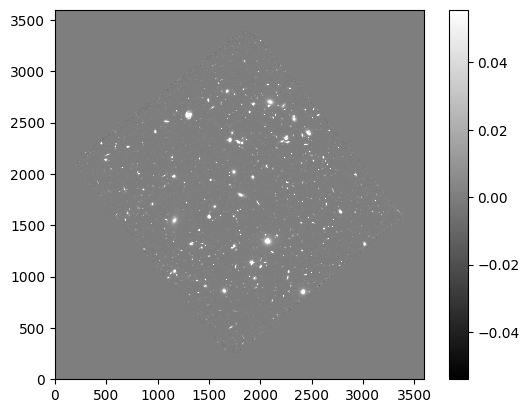

In [50]:
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()

In [51]:
#BIT SWAP REQUIRED BECAUSE OF ASTROPY.IO.FITS
new_data = data.astype(data.dtype.newbyteorder("="))
new_data = data.byteswap()
new_data = new_data.view(new_data.dtype.newbyteorder("="))
data = data.byteswap()
data = data.view(data.dtype.newbyteorder("="))
#Should be done right after the reading of the array. right here!

In [52]:
bkg = sep.Background(data)

#mask out anything with a background width of 64 and height of 64 and a foreground width of 3 and height of 3
#common trick to take out "similar" large chunks.
print(bkg.globalback)
#global mean
print(bkg.globalrms)
#background noise

0.0
0.0005398219218477607


In [53]:
bkg_image = bkg.back()
#uses self as input
#creates array

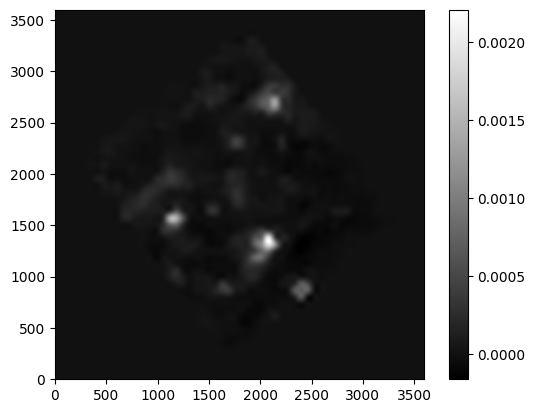

In [54]:
plt.imshow(bkg_image, interpolation='nearest', cmap= 'gray', origin='lower')
plt.colorbar()

In [55]:
bkg_rms = bkg.rms()

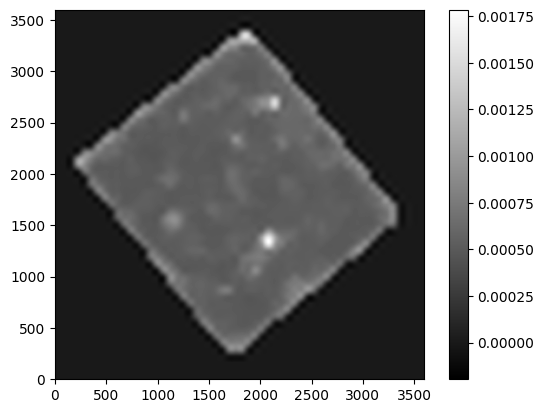

In [56]:
plt.imshow(bkg_rms, interpolation='nearest', cmap= 'gray', origin='lower')
plt.colorbar()
#show background noise
#that looks so cool what
#idk if it looks right, per se

In [57]:
data_sub = data - bkg
#subtract background

Object Detection

In [58]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [67]:
len(objects)
print(f"Number of objects: {len(objects)}")

Number of objects: 8640


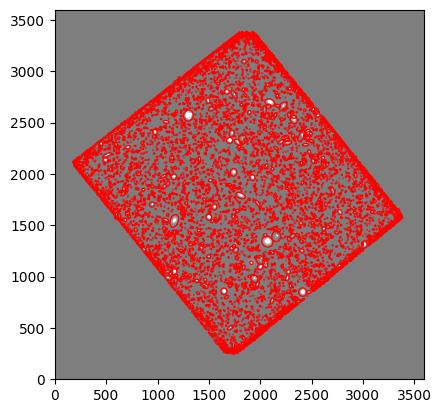

In [60]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)


In [61]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

In [62]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)

In [63]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


I don't know if I did this right. let me go back
apparently that looks good (even if it's got a LOT of objects)

Part 6: Histogram

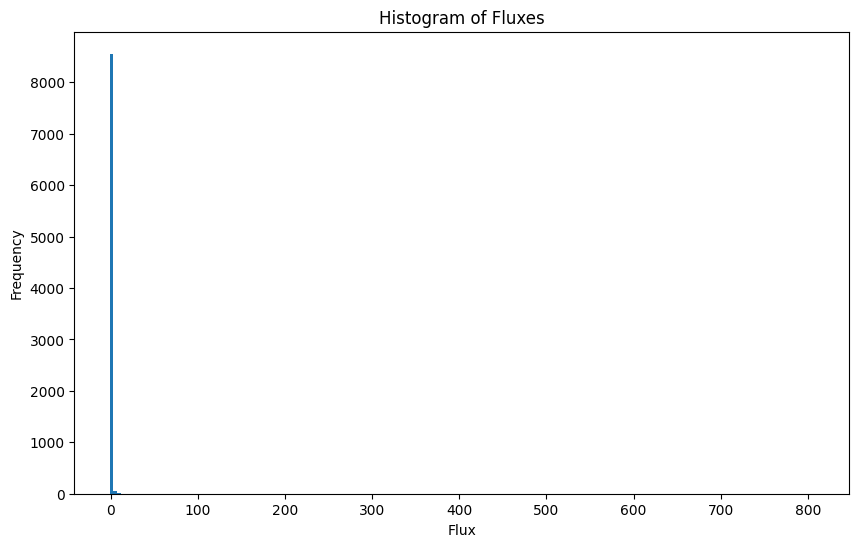

In [64]:
# Histogram of fluxes
plt.figure(figsize=(10, 6))
plt.hist(flux, bins='auto')
plt.xlabel('Flux')
plt.ylabel('Frequency')
plt.title('Histogram of Fluxes')
plt.show()

Part 7

In [65]:
print(f"Mean {np.mean(flux):.2f}")
print(f"Median {np.median(flux):.2f}")
print(f"Standard Deviation {np.std(flux):.2f}")

#largest outlier
#we only need the max because... look at that histogram :skull:
max_flux_value = flux[np.argmax(flux)]

#Calculate Sigma (how many standard deviations away from the mean)
sigma_distance = (max_flux_value - np.mean(flux)) / np.std(flux)

#Get the X, Y coordinates
outlier_x = objects['x'][np.argmax(flux)]
outlier_y = objects['y'][np.argmax(flux)]
#print data
print(f"Largest Outlier: {max_flux_value:.2f}")
print(f"x={outlier_x:.2f}, y={outlier_y:.2f}")
print(f"Sigma {sigma_distance:.2f}")

Mean 0.36
Median 0.03
Standard Deviation 9.24
Largest Outlier: 807.30
x=1914.25, y=1134.32
Sigma 87.30


Step 8

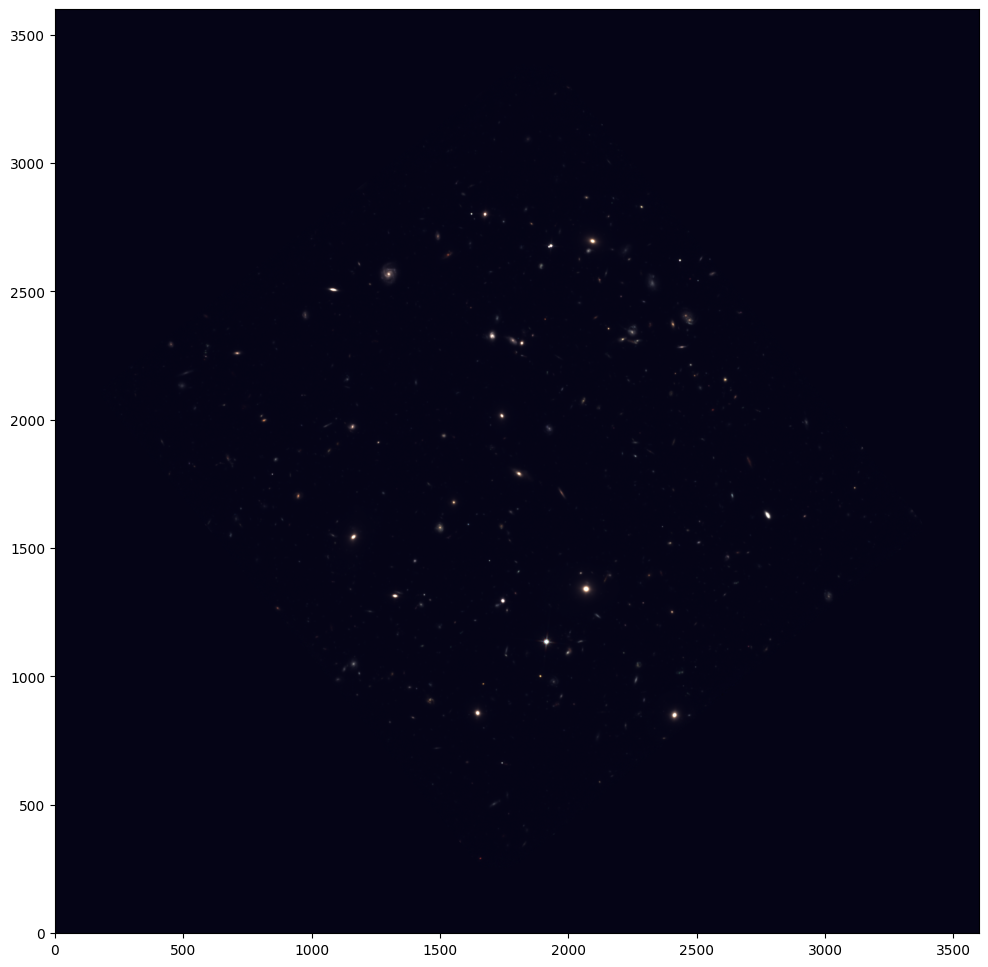

In [68]:
#load all that data using fun trick that saves headache
f105w = fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits')[0].data
f125w = fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits')[0].data
f160w = fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits')[0].data

#helper function
def normalize_image(arr):
    # Calculate mean and standard deviation
    m, s = np.mean(arr), np.std(arr)
    # Clip bright outliers at 10 sigmas so faint stuff shows up
    arr_clipped = np.clip(arr, m - s, m + 10*s)
    # Scale to 0-1
    return (arr_clipped - np.min(arr_clipped)) / (np.max(arr_clipped) - np.min(arr_clipped))

#Create 3d array from the 105 input data
rgb_image = np.zeros((f105w.shape[0], f105w.shape[1], 3))

#assign each image to a color.
#Red = f160w, Green = f125w, Blue = f105w
rgb_image[:,:,0] = normalize_image(f160w) # Red
rgb_image[:,:,1] = normalize_image(f125w) # Green
rgb_image[:,:,2] = normalize_image(f105w) # Blue

#Plot and Save
plt.figure(figsize=(12, 12))
plt.imshow(rgb_image, origin='lower')

#save image :) 150 dpi should be enough.
plt.savefig('hudf_false_color.png', dpi=150, bbox_inches='tight')
plt.show()